# Feature detection com BRISK em OpenCV


Exemplos extraídos do tutorial  [Scipy4CV ministrado por Thiago Santos no Simpósio Brasileiro de Computação Gráfica e Processamento de Imagens](https://github.com/thsant/scipy4cv)

Referências para este assunto:

[Computer Vision - Algorithms and Applications. Richard Szeliski](http://szeliski.org/Book/)
- Capítulo 3 - Image processing
- Capítulo 4 - Feature Detectors and Matching
    
[Capítulo 2 - Local Image Descriptors do Livro de Python/OpenCV de Jan Solem](http://programmingcomputervision.com/downloads/ProgrammingComputerVision_CCdraft.pdf)

Os livros técnicos falam bastante da técnica chamada *SIFT*, e é uma técnica que permite encontrar pontos únicos em uma imagem e identificá-los novamente em outras imagens. Esta é uma técnica bastante usada na literatura de visão computacional.

Infelizmente a SIFT foi removida da maioria das distribuições da OpenCV porque é uma técnica patenteada e a patente ainda está válida. Por este motivo vamos trabalhar com  o BRISK [(Binary Robust Invariant Scale Keypoints)](https://arxiv.org/pdf/1710.02726.pdf), que é uma técnica similar.




In [1]:

import numpy as np
import cv2
from matplotlib import pyplot as plt
from math import pi
import matplotlib.cm as cm

# Enxergando as features

In [2]:
book_bgr = cv2.imread('arduino_capa.png')
book_gray = cv2.cvtColor(book_bgr, cv2.COLOR_BGR2GRAY)


A função `cv2.BRISK_create()` identifica as *features* únicas de uma imagem

In [3]:
brisk = cv2.BRISK_create() # Nota: numa versão anterior era a BRISK
kpts = brisk.detect(book_gray)
x = [k.pt[0] for k in kpts]
y = [k.pt[1] for k in kpts]
# s will correspond to the neighborhood area
s = [(k.size/2)**2 * pi for k in kpts]


Vamos visualizar as imagens com as features. Note que cada círculo corresponde a uma feature e sua região de influência

Text(0.5, 1.0, 'BRISK')

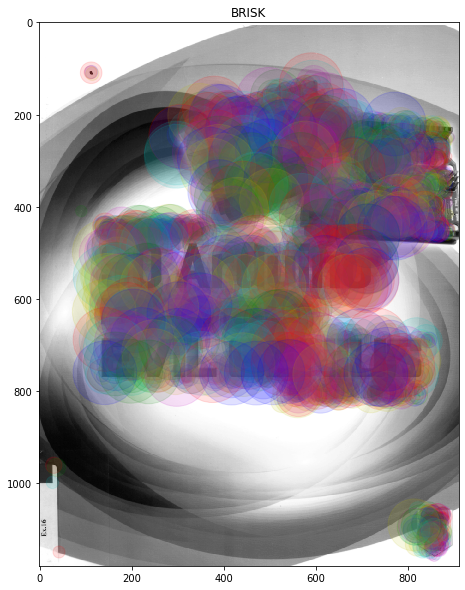

In [4]:
plt.figure(figsize=(20,10))
colors = list("bgrcmy")
cores_grafico = np.random.choice(colors, size=len(x), replace=True)
plt.scatter(x, y, s, c=cores_grafico, alpha=0.12)
plt.imshow(book_gray, cmap=cm.gray)
plt.title('BRISK')

In [5]:
# Essa função vai ser usada abaixo. Ela encontra a matriz (homografia) 
# que quando multiplicada pela imagem de entrada gera a imagem de 


def find_homography_draw_box(kp1, kp2, img_cena):
    
    out = img_cena.copy()
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)


    # Tenta achar uma trasformacao composta de rotacao, translacao e escala que situe uma imagem na outra
    # Esta transformação é chamada de homografia 
    # Para saber mais veja 
    # https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()


    
    h,w = img_original.shape
    # Um retângulo com as dimensões da imagem original
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Transforma os pontos do retângulo para onde estao na imagem destino usando a homografia encontrada
    dst = cv2.perspectiveTransform(pts,M)


    # Desenha um contorno em vermelho ao redor de onde o objeto foi encontrado
    img2b = cv2.polylines(out,[np.int32(dst)],True,(255,255,0),5, cv2.LINE_AA)
    
    return img2b
    

## O que implementar em seu código

O exemplo abaixo carrega duas imagens. A `img_original` é o objeto a ser encontrado, e a `img_cena` contém uma cena que contém o objeto

In [6]:
# Número mínimo de pontos correspondentes
MIN_MATCH_COUNT = 10

cena_bgr = cv2.imread("arduino_mesa.jpg") # Imagem do cenario
original_bgr = book_bgr

# Versões RGB das imagens, para plot
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
cena_rgb = cv2.cvtColor(cena_bgr, cv2.COLOR_BGR2RGB)

## Localização e matching das features

In [7]:
# Versões grayscale para feature matching
img_original = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2GRAY)
img_cena = cv2.cvtColor(cena_bgr, cv2.COLOR_BGR2GRAY)

framed = None

# Imagem de saída
out = cena_rgb.copy()


# Cria o detector BRISK
brisk = cv2.BRISK_create()

# Encontra os pontos únicos (keypoints) nas duas imagems
kp1, des1 = brisk.detectAndCompute(img_original ,None)
kp2, des2 = brisk.detectAndCompute(img_cena,None)

# Configura o algoritmo de casamento de features que vê *como* o objeto que deve ser encontrado aparece na imagem
bf = cv2.BFMatcher(cv2.NORM_HAMMING)


# Tenta fazer a melhor comparacao usando o algoritmo
matches = bf.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


if len(good)>MIN_MATCH_COUNT:
    # Separa os bons matches na origem e no destino
    print("Matches found")    
    framed = find_homography_draw_box(kp1, kp2, cena_rgb)
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))


Matches found


## Objeto localizado

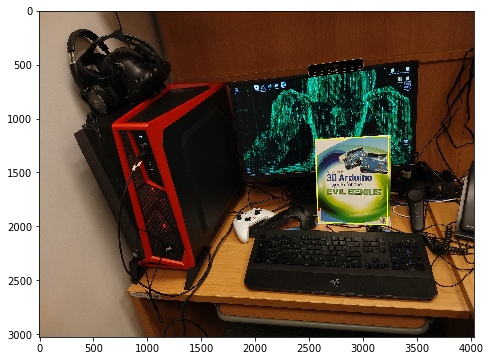

In [8]:
plt.figure(figsize=(15,6))
plt.imshow(framed)

Vamos rever os feature points da imagem

##  Desenhando as correspondências

A OpenCV tem a função `drawMatches`, que permite desenhar os feature points encontrados

In [9]:
#np.random.choice(matches,100)
img3 = cv2.drawMatches(original_rgb,kp1,cena_rgb,kp2, good,       None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

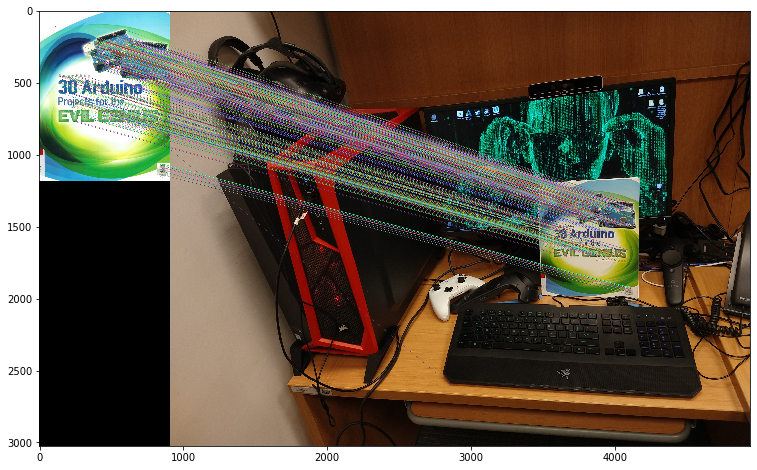

In [10]:
plt.figure(figsize=(13,8))
plt.imshow(img3)